## PySCF with OpenFermion

Oxygen bond length optimisation

Based on the examples from:

[https://github.com/quantumlib/OpenFermion-PySCF](https://github.com/quantumlib/OpenFermion-PySCF)

[https://quantumai.google/openfermion/tutorials](https://quantumai.google/openfermion/tutorials)

In [1]:
import io
from ase.io.xyz import write_xyz
from ase.visualize import view
from ase.build import molecule
atoms = molecule('LiH')
view(atoms, viewer='x3d')

In [2]:
def create_molecule(bond_length: float):
    f = io.StringIO()
    atoms[0].c=0.
    atoms[1].c=bond_length
    atoms.write(f,format='xyz')
    return [(a.split()[0],(float(a.split()[1]),float(a.split()[2]),float(a.split()[3]))) for a in f.getvalue().split('\n')[2:-1]]


At bond length of 1.5 angstrom, molecular oxygen has:
Hartree-Fock energy of -7.863357621535113 Hartree.


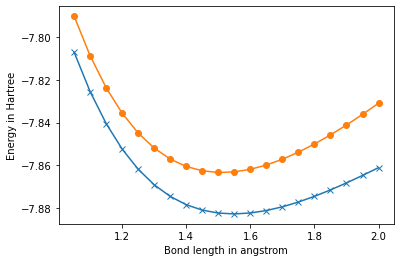

In [5]:
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf

# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1
n_points = 20
bond_length_interval = 1.0 / n_points

# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1
delete_input = True
delete_output = True

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
bond_lengths = []
best_bond_length=None
best_hf_energy=None
for point in range(1, n_points + 1):
    bond_length = bond_length_interval * float(point) + 1.0
    bond_lengths += [bond_length]
    geometry = create_molecule(bond_length)
    molecule = MolecularData(
        geometry, basis, multiplicity,
        description=str(round(bond_length, 2)))
    
    # Run pyscf.
    molecule = run_pyscf(molecule,
                         run_scf=run_scf,
                         run_mp2=run_mp2,
                         run_cisd=run_cisd,
                         run_ccsd=run_ccsd,
                         run_fci=run_fci)

    # Print out some results of calculation.
    #print(f'\nAt bond length of {bond_length} angstrom, molecular oxygen has:')
    #print(f'Hartree-Fock energy of {molecule.hf_energy} Hartree.')
    #print(f'MP2 energy of {molecule.mp2_energy} Hartree.')
    #print(f'FCI energy of {molecule.fci_energy} Hartree.')
    #print(f'Nuclear repulsion energy between protons is {molecule.nuclear_repulsion} Hartree.')
    #for orbital in range(molecule.n_orbitals):
    #    print(f'Spatial orbital {orbital} has energy of {molecule.orbital_energies[orbital]} Hartree.')
    
    hf_energies += [molecule.hf_energy]
    fci_energies += [molecule.fci_energy]
    
    if not best_bond_length:
        best_bond_length = bond_length
        best_hf_energy = molecule.hf_energy
    elif best_hf_energy > molecule.hf_energy:
        best_hf_energy = molecule.hf_energy
        best_bond_length = bond_length
        

print(f'\nAt bond length of {best_bond_length} angstrom, molecular oxygen has:')
print(f'Hartree-Fock energy of {best_hf_energy} Hartree.')
        
# Plot.
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(0)
plt.plot(bond_lengths, fci_energies, 'x-')
plt.plot(bond_lengths, hf_energies, 'o-')
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()

In [6]:
lih_molecule=molecule
one_body_integrals=lih_molecule.one_body_integrals
one_body_integrals

array([[-4.66166625e+00,  9.66960938e-02,  1.62855835e-01,
         1.66574019e-18, -5.67481030e-17, -5.11135182e-02],
       [ 9.66960938e-02, -1.35171060e+00,  1.99252288e-02,
         2.77233021e-16,  3.25501044e-16,  2.55559992e-02],
       [ 1.62855835e-01,  1.99252288e-02, -1.10132417e+00,
        -1.52269396e-16, -2.64034323e-18,  2.28740315e-02],
       [ 1.66574019e-18,  2.77233021e-16, -1.52269396e-16,
        -1.10164930e+00, -2.22044605e-16, -9.12282972e-17],
       [-5.67481030e-17,  3.25501044e-16, -2.64034323e-18,
        -2.77555756e-16, -1.10164930e+00,  2.98901605e-16],
       [-5.11135182e-02,  2.55559992e-02,  2.28740315e-02,
        -9.12282972e-17,  2.98901605e-16, -1.00383684e+00]])

In [7]:
from openfermion.transforms import get_fermion_operator, jordan_wigner
lih_qubit_hamiltonian = jordan_wigner(get_fermion_operator(lih_molecule.get_molecular_hamiltonian()))
lih_qubit_hamiltonian

(-4.243807131072285+0j) [] +
(-0.0026339817422783513+0j) [X0 X1 Y2 Y3] +
(-0.0026512285284594774+0j) [X0 X1 Y2 Z3 Z4 Y5] +
(0.002346057207376457+0j) [X0 X1 Y2 Z3 Z4 Z5 Z6 Z7 Z8 Z9 Z10 Y11] +
(-0.002651228528459478+0j) [X0 X1 X3 X4] +
(0.002346057207376457+0j) [X0 X1 X3 Z4 Z5 Z6 Z7 Z8 Z9 X10] +
(-0.005497222044567241+0j) [X0 X1 Y4 Y5] +
(0.0010830124355701415+0j) [X0 X1 Y4 Z5 Z6 Z7 Z8 Z9 Z10 Y11] +
(0.0010830124355701415+0j) [X0 X1 X5 Z6 Z7 Z8 Z9 X10] +
(-0.002452693385643852+0j) [X0 X1 Y6 Y7] +
(-0.0024526933856438525+0j) [X0 X1 Y8 Y9] +
(-0.0026931496735318893+0j) [X0 X1 Y10 Y11] +
(0.0026339817422783513+0j) [X0 Y1 Y2 X3] +
(0.0026512285284594774+0j) [X0 Y1 Y2 Z3 Z4 X5] +
(-0.002346057207376457+0j) [X0 Y1 Y2 Z3 Z4 Z5 Z6 Z7 Z8 Z9 Z10 X11] +
(-0.002651228528459478+0j) [X0 Y1 Y3 X4] +
(0.002346057207376457+0j) [X0 Y1 Y3 Z4 Z5 Z6 Z7 Z8 Z9 X10] +
(0.005497222044567241+0j) [X0 Y1 Y4 X5] +
(-0.0010830124355701415+0j) [X0 Y1 Y4 Z5 Z6 Z7 Z8 Z9 Z10 X11] +
(0.0010830124355701415+0j) [X0 Y1 Y5 Z6

In [8]:
from openfermion.linalg import get_sparse_operator
from scipy.linalg import eigh

lih_matrix = get_sparse_operator(lih_qubit_hamiltonian).todense()
eighgenvalues, eigenvectors = eigh(lih_matrix)

In [11]:
import openfermion

hamiltonian = lih_molecule.get_molecular_hamiltonian()
print(openfermion.get_fermion_operator(hamiltonian))

0.7937658163800001 [] +
-4.661666245056378 [0^ 0] +
0.8295759976536229 [0^ 0^ 0 0] +
-0.050059100852387864 [0^ 0^ 0 2] +
-0.0705585553080134 [0^ 0^ 0 4] +
0.03417119619928826 [0^ 0^ 0 10] +
-0.050059100852387836 [0^ 0^ 2 0] +
0.005267963484556703 [0^ 0^ 2 2] +
0.005302457056918953 [0^ 0^ 2 4] +
-0.004692114414752914 [0^ 0^ 2 10] +
-0.07055855530801343 [0^ 0^ 4 0] +
0.005302457056918957 [0^ 0^ 4 2] +
0.01099444408913448 [0^ 0^ 4 4] +
-0.0021660248711402835 [0^ 0^ 4 10] +
0.004905386771287703 [0^ 0^ 6 6] +
0.004905386771287705 [0^ 0^ 8 8] +
0.03417119619928823 [0^ 0^ 10 0] +
-0.004692114414752913 [0^ 0^ 10 2] +
-0.0021660248711402826 [0^ 0^ 10 4] +
0.005386299347063779 [0^ 0^ 10 10] +
0.8295759976536229 [0^ 1^ 1 0] +
-0.050059100852387864 [0^ 1^ 1 2] +
-0.0705585553080134 [0^ 1^ 1 4] +
0.03417119619928826 [0^ 1^ 1 10] +
-0.050059100852387836 [0^ 1^ 3 0] +
0.005267963484556703 [0^ 1^ 3 2] +
0.005302457056918953 [0^ 1^ 3 4] +
-0.004692114414752914 [0^ 1^ 3 10] +
-0.07055855530801343 [0^ 1^

In [13]:
import cirq
import openfermion
from openfermion.circuits import trotter

# Trotter step parameters.
time = 1.
final_rank = 2

# Initialize circuit qubits in a line.
n_qubits = openfermion.count_qubits(hamiltonian)
qubits = cirq.LineQubit.range(n_qubits)

# Compile the low rank Trotter step using OpenFermion.
custom_algorithm = trotter.LowRankTrotterAlgorithm(final_rank=final_rank)
circuit = cirq.Circuit(
    trotter.simulate_trotter(
            qubits, hamiltonian,
            time=time, omit_final_swaps=True,
            algorithm=custom_algorithm),
    strategy=cirq.InsertStrategy.EARLIEST)

# Print circuit.
cirq.DropNegligible().optimize_circuit(circuit)
print(circuit.to_text_diagram(transpose=True))

0             1                    2                3                      4                      5                      6                    7                     8                9                     10                   11
│             │                    │                │                      │                      │                      │                    │                     │                │                     │                    │
│             Rz(π)                Rz(π)            │                      Rz(π)                  Rz(π)                  │                    Rz(π)                 │                │                     │                    Rz(π)
│             │                    │                │                      │                      │                      │                    │                     │                │                     │                    │
│             │                    │                │                      │               

In [14]:
# Initialize a random initial state.
import numpy
random_seed = 8317
initial_state = openfermion.haar_random_vector(
    2 ** n_qubits, random_seed).astype(numpy.complex64)

# Numerically compute the correct circuit output.
import scipy
hamiltonian_sparse = openfermion.get_sparse_operator(hamiltonian)
exact_state = scipy.sparse.linalg.expm_multiply(
    -1j * time * hamiltonian_sparse, initial_state)

# Trotter step parameters.
n_steps = 3

# Compile the low rank Trotter step using OpenFermion.
qubits = cirq.LineQubit.range(n_qubits)
circuit = cirq.Circuit(
    trotter.simulate_trotter(
            qubits, hamiltonian,
            time=time, n_steps=n_steps,
            algorithm=trotter.LOW_RANK),
    strategy=cirq.InsertStrategy.EARLIEST)

# Use Cirq simulator to apply circuit.
simulator = cirq.Simulator()
result = simulator.simulate(circuit, qubit_order=qubits, initial_state=initial_state)
simulated_state = result.final_state_vector

# Print final fidelity.
fidelity = abs(numpy.dot(simulated_state, numpy.conjugate(exact_state))) ** 2
print('Fidelity with exact result is {}.\n'.format(fidelity))

# Print circuit.
cirq.DropNegligible().optimize_circuit(circuit)
print(circuit.to_text_diagram(transpose=True))

Fidelity with exact result is 0.9947513387365631.

0             1                     2                    3                      4                      5                      6                    7                      8                      9                      10                   11
│             │                     │                    │                      │                      │                      │                    │                      │                      │                      │                    │
│             Rz(π)                 Rz(π)                │                      Rz(π)                  Rz(π)                  │                    Rz(π)                  │                      │                      │                    Rz(π)
│             │                     │                    │                      │                      │                      │                    │                      │                      │                      │          